In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import os
import glob

from collections import Counter, defaultdict
from tqdm import tqdm
from scipy import stats

mpl.rcParams['figure.dpi'] = 150
plt.rc('font', family='FreeSans', size=7)

plt.rc('figure', figsize=(1.5, 1.5))

pd.set_option("display.max_columns", None)

def save_figures(f, exts=['png', 'pdf']):
    for ext in exts:
        plt.savefig(f + f'.{ext}', dpi=300, bbox_inches='tight', transparent=True)

In [2]:
from pybiomart import Dataset
dataset = Dataset(name='hsapiens_gene_ensembl', host='http://www.ensembl.org')
res = dataset.query(attributes=['ensembl_gene_id', 'external_gene_name', 'gene_biotype'])

ensg2symbol = {r['Gene stable ID']:r['Gene name'] for r in res.to_records()}

/data/project/dohoon/miniconda3/envs/analysis/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


## Expression values

In [3]:
def read_rsem_result(f, sample_name):
    tmp = pd.read_csv(f, sep='\t')
    tmp['gene_id'] = tmp.gene_id.str.split('.', expand=True)[0]
    tmp = tmp.set_index('gene_id').rename({'TPM': sample_name}, axis=1)
    return tmp[[sample_name]]

In [4]:
sample_names = [
    'WT-1_6', 'WT-2_6',
    'WT-1_24', 'WT-2_24',
    'D49-1_6', 'D49-2_6',
    'D49-1_24', 'D49-2_24',
]

In [ ]:
exps = pd.concat([read_rsem_result(f'/data/project/dohoon/workbench/2305-sw/snakemake-star-rsem/result/03_rsem/{sample_name}.genes.results', sample_name) for sample_name in sample_names], axis=1)
exps['gene_symbol'] = exps.index.map(ensg2symbol)
cols = ['gene_symbol'] + [col for col in exps.columns if col != 'gene_symbol']
exps = exps[cols].reset_index().rename({'gene_id': 'ensg'}, axis=1)

In [ ]:
exps.head(3)

In [21]:
exps.to_excel('result/expression.xlsx', index=False)

In [159]:
exps = pd.read_excel('result/expression.xlsx')

## DEG analysis result

In [197]:
def read_deseq_result(f):
    tmp = pd.read_csv(f, index_col=0)
    tmp.index = [ind.split('.')[0] for ind in tmp.index.values]
    tmp.index.name = 'ensg'
    tmp['gene_symbol'] = tmp.index.map(ensg2symbol)
    
    return tmp.reset_index()[['gene_symbol', 'ensg', 'baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue', 'padj']]

t6_deseq = read_deseq_result('/data/project/dohoon/workbench/2305-sw/snakemake-star-rsem/6hpi_degs.csv')
t24_deseq = read_deseq_result('/data/project/dohoon/workbench/2305-sw/snakemake-star-rsem/24hpi_degs.csv')

In [173]:
t6_deseq_notnull = t6_deseq[t6_deseq.padj.notnull()]
t24_deseq_notnull = t24_deseq[t24_deseq.padj.notnull()]

In [198]:
t6_deseq

,gene_symbol,ensg,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,TSPAN6,ENSG00000000003,588.486327,0.155752,0.163384,0.953292,0.340442,0.656265
1,DPM1,ENSG00000000419,1242.991392,0.138273,0.124991,1.106264,0.268612,0.588603
2,SCYL3,ENSG00000000457,254.478863,0.024012,0.241659,0.099363,0.920850,0.974989
3,C1orf112,ENSG00000000460,182.125973,-0.181683,0.286317,-0.634553,0.525720,0.790611
4,FGR,ENSG00000000938,19.085791,-1.581041,0.832900,-1.898235,0.057665,NaN
...,...,...,...,...,...,...,...,...
23271,NaN,ENSG00000288398,120.622866,0.293930,0.324115,0.906869,0.364476,0.676707
23272,NaN,ENSG00000288436,1.043920,1.497646,3.775553,0.396669,0.691611,NaN
23273,NaN,ENSG00000288437,1.844320,1.286645,2.696786,0.477103,0.633289,NaN
23274,NaN,ENSG00000288473,23.242218,-0.050848,0.733601,-0.069313,0.944740,NaN


## GO term analysis

In [174]:
exps[exps.ensg == 'ENSG00000254692']

,ensg,gene_symbol,WT-1_6,WT-2_6,WT-1_24,WT-2_24,D49-1_6,D49-2_6,D49-1_24,D49-2_24
42193,ENSG00000254692,NaN,0.7,0.0,0.53,0.83,0.0,0.48,0.0,0.4


In [175]:
import gseapy as gp

In [176]:
t6_d49_high = t6_deseq_notnull[(t6_deseq_notnull.padj < 0.05) & (t6_deseq_notnull.log2FoldChange < 0)].gene_symbol.dropna().tolist()
t6_d49_low = t6_deseq_notnull[(t6_deseq_notnull.padj < 0.05) & (t6_deseq_notnull.log2FoldChange > 0)].gene_symbol.dropna().tolist()

t24_d49_high = t24_deseq_notnull[(t24_deseq_notnull.padj < 0.05) & (t24_deseq_notnull.log2FoldChange < 0)].gene_symbol.dropna().tolist()
t24_d49_low = t24_deseq_notnull[(t24_deseq_notnull.padj < 0.05) & (t24_deseq_notnull.log2FoldChange > 0)].gene_symbol.dropna().tolist()

len(t6_d49_high), len(t6_d49_low), len(t24_d49_high), len(t24_d49_low)

(759, 400, 400, 92)

In [177]:
t6_d49_high_fc = t6_deseq_notnull[(t6_deseq_notnull.padj < 0.05) & (t6_deseq_notnull.log2FoldChange < -1)].gene_symbol.dropna().tolist()
t6_d49_low_fc = t6_deseq_notnull[(t6_deseq_notnull.padj < 0.05) & (t6_deseq_notnull.log2FoldChange > 1)].gene_symbol.dropna().tolist()

t24_d49_high_fc = t24_deseq_notnull[(t24_deseq_notnull.padj < 0.05) & (t24_deseq_notnull.log2FoldChange < -1)].gene_symbol.dropna().tolist()
t24_d49_low_fc = t24_deseq_notnull[(t24_deseq_notnull.padj < 0.05) & (t24_deseq_notnull.log2FoldChange > 1)].gene_symbol.dropna().tolist()

len(t6_d49_high_fc), len(t6_d49_low_fc), len(t24_d49_high_fc), len(t24_d49_low_fc)

(80, 13, 34, 6)

In [178]:
gp.__version__

'0.10.8'

In [179]:
deg_keys = ['t6_d49_high', 't6_d49_low', 't24_d49_high', 't24_d49_low', 't6_all_degs', 't24_all_degs']
deg_genes = [t6_d49_high, t6_d49_low, t24_d49_high, t24_d49_low, t6_d49_high+t6_d49_low, t24_d49_high+t24_d49_low]

go_result = dict()
for key, genes in tqdm(zip(deg_keys, deg_genes)):
    go_result[key] = gp.enrichr(genes, 'GO_Biological_Process_2018').res2d.sort_values('Adjusted P-value')

0it [00:00, ?it/s]/data/project/dohoon/miniconda3/envs/analysis/lib/python3.9/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
1it [00:07,  7.70s/it]/data/project/dohoon/miniconda3/envs/analysis/lib/python3.9/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
2it [00:12,  5.95s/it]/data/project/dohoon/miniconda3/envs/analysis/lib/python3.9/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
3it [00:17,  5.44s/it]/data/project/dohoon/miniconda3/envs/analys

In [185]:
go_result['t6_d49_high']

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2018,cellular response to type I interferon (GO:007...,39/65,5.876667e-39,9.543707e-36,0,0,40.031250,3523.944088,IFITM3;IFITM1;SP100;IFITM2;IFI6;ADAR;IFI35;IFI...
1,GO_Biological_Process_2018,type I interferon signaling pathway (GO:0060337),39/65,5.876667e-39,9.543707e-36,0,0,40.031250,3523.944088,IFITM3;IFITM1;SP100;IFITM2;IFI6;ADAR;IFI35;IFI...
2,GO_Biological_Process_2018,cytokine-mediated signaling pathway (GO:0019221),103/633,4.126737e-37,4.467880e-34,0,0,5.543123,464.392653,IFITM3;IFITM1;IFITM2;CSF1;IFI35;IFI30;IFIT1;IF...
3,GO_Biological_Process_2018,cellular response to interferon-gamma (GO:0071...,39/116,1.081340e-26,8.780483e-24,0,0,13.481169,806.025754,SP100;CCL3L1;IFI30;ICAM1;OASL;MT2A;CCL8;CCL7;T...
4,GO_Biological_Process_2018,interferon-gamma-mediated signaling pathway (G...,30/70,1.783097e-24,1.158300e-21,0,0,19.754115,1080.227918,SP100;IFI30;ICAM1;OASL;MT2A;TRIM5;TRIM25;TRIM2...
...,...,...,...,...,...,...,...,...,...,...
3243,GO_Biological_Process_2018,gene expression (GO:0010467),8/411,9.891040e-01,9.903236e-01,0,0,0.497943,0.005455,MRPS24;RPL13A;BAZ2A;BAZ1A;RPL8;RPL28;LMF2;RBMS2
3244,GO_Biological_Process_2018,ribosome biogenesis (GO:0042254),3/226,9.923454e-01,9.932628e-01,0,0,0.338423,0.002600,RPL13A;RPL8;RPL28
3245,GO_Biological_Process_2018,"RNA splicing, via transesterification reaction...",3/236,9.944020e-01,9.950147e-01,0,0,0.323728,0.001817,PUF60;GTF2F1;CTNNBL1
3246,GO_Biological_Process_2018,mRNA processing (GO:0006397),4/283,9.948827e-01,9.951891e-01,0,0,0.360075,0.001847,PUF60;GTF2F1;CMTR1;CTNNBL1


In [181]:
dataset.filters

{'link_so_mini_closure': <biomart.Filter name='link_so_mini_closure', type='list'>,
 'link_go_closure': <biomart.Filter name='link_go_closure', type='text'>,
 'link_ensembl_transcript_stable_id': <biomart.Filter name='link_ensembl_transcript_stable_id', type='text'>,
 'gene_id': <biomart.Filter name='gene_id', type='text'>,
 'transcript_id': <biomart.Filter name='transcript_id', type='text'>,
 'link_ensembl_gene_id': <biomart.Filter name='link_ensembl_gene_id', type='text'>,
 'chromosome_name': <biomart.Filter name='chromosome_name', type='text'>,
 'start': <biomart.Filter name='start', type='text'>,
 'end': <biomart.Filter name='end', type='text'>,
 'band_start': <biomart.Filter name='band_start', type='drop_down_basic_filter'>,
 'band_end': <biomart.Filter name='band_end', type='drop_down_basic_filter'>,
 'marker_start': <biomart.Filter name='marker_start', type='drop_down_basic_filter'>,
 'marker_end': <biomart.Filter name='marker_end', type=''>,
 'hsapiens_encode.type': <biomart.Fi

In [182]:
with open('GO_Biological_Process_2018.txt') as inFile:
    for l in inFile.readlines():
        toks = l.strip().split('\t')
        if 'GO:0071357' in toks[0]:
            interf_genes = [t for t in toks[1:] if t]

In [183]:
len(interf_genes)

65

In [184]:
go_result['t24_d49_high']

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2018,cytokine-mediated signaling pathway (GO:0019221),87/633,6.614767e-48,1.568361e-44,0,0,9.699926,1053.749356,IFITM3;CSF3;IFITM1;IFITM2;CXCL8;CSF1;CXCL1;ADA...
1,GO_Biological_Process_2018,cellular response to type I interferon (GO:007...,36/65,2.075785e-44,1.640562e-41,0,0,66.744600,6713.399146,IFITM3;IFITM1;SP100;IFITM2;IFI6;ADAR;IFI35;IFI...
2,GO_Biological_Process_2018,type I interferon signaling pathway (GO:0060337),36/65,2.075785e-44,1.640562e-41,0,0,66.744600,6713.399146,IFITM3;IFITM1;SP100;IFITM2;IFI6;ADAR;IFI35;IFI...
3,GO_Biological_Process_2018,interferon-gamma-mediated signaling pathway (G...,29/70,3.720459e-31,2.205302e-28,0,0,37.289527,2612.738863,SP100;CAMK2D;IFI30;ICAM1;OASL;TRIM5;TRIM25;TRI...
4,GO_Biological_Process_2018,cellular response to interferon-gamma (GO:0071...,34/116,2.301672e-30,1.091453e-27,0,0,22.111555,1508.979148,SP100;CAMK2D;IFI30;ICAM1;OASL;TRIM5;CCL5;CASP1...
...,...,...,...,...,...,...,...,...,...,...
2366,GO_Biological_Process_2018,cellular protein complex assembly (GO:0043623),1/144,9.460510e-01,9.476497e-01,0,0,0.341010,0.018912,CLU
2367,GO_Biological_Process_2018,spermatogenesis (GO:0007283),1/153,9.550813e-01,9.562913e-01,0,0,0.320670,0.014738,TDRD7
2368,GO_Biological_Process_2018,male gamete generation (GO:0048232),1/154,9.559866e-01,9.567936e-01,0,0,0.318558,0.014339,TDRD7
2369,GO_Biological_Process_2018,cilium assembly (GO:0060271),2/288,9.801580e-01,9.805716e-01,0,0,0.339354,0.006801,EHD1;RAB8A


In [29]:
with pd.ExcelWriter('result/go_term_analysis_result.xlsx') as writer:
    exps.to_excel(writer, sheet_name='expression_table', index=False)
    t6_deseq.to_excel(writer, sheet_name='WT-6_vs_D49-6', index=False)
    t24_deseq.to_excel(writer, sheet_name='WT-24_vs_D49-24', index=False)
    
    for deg_key in deg_keys:
        go_result[deg_key].to_excel(writer, sheet_name=deg_key + '_GO_term', index=False)

### Expression values of genes belonging to cytokine-mediated signaling pathway 

In [30]:
np.log2(exps[
    exps.gene_symbol.isin(go_result['t24_d49_high'].iloc[0].Genes.split(';'))
].set_index(['ensg', 'gene_symbol']) + 1).reset_index().to_excel('result/cytokine_mediated_signaling_87genes.xlsx', index=False)

In [186]:
genes = [
    'MX1',
    'OAS1',
    'IFNB1',
    'CCL3',
    'CCL5',
    'CXCL10',
    'CXCL11',
    'CCL20',
    'RSAD2',
    'TNFSF18',
]

In [187]:
exps

,ensg,gene_symbol,WT-1_6,WT-2_6,WT-1_24,WT-2_24,D49-1_6,D49-2_6,D49-1_24,D49-2_24
0,ENSG00000000003,TSPAN6,12.02,12.99,13.89,12.76,9.86,11.24,14.52,12.95
1,ENSG00000000005,TNMD,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,ENSG00000000419,DPM1,90.29,76.39,127.08,140.60,73.57,69.02,121.92,106.80
3,ENSG00000000457,SCYL3,4.85,4.31,7.03,5.20,3.69,4.76,5.31,5.67
4,ENSG00000000460,C1orf112,4.72,3.68,12.22,13.35,5.23,3.81,13.66,11.08
...,...,...,...,...,...,...,...,...,...,...
60567,ENSG00000288459,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
60568,ENSG00000288460,SMIM42,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
60569,ENSG00000288473,NaN,0.24,0.21,0.10,0.17,0.17,0.26,0.26,0.18
60570,ENSG00000288484,DYNAPP3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Text(376.04166666666663, 0.5, '')

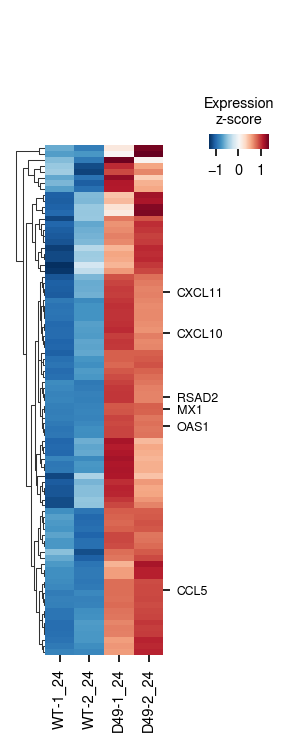

In [188]:
# d = np.log2(exps[
#     exps.gene_symbol.isin(go_result['t18_d49_high'].iloc[0].Genes.split(';'))
# ].set_index(['ensg', 'gene_symbol']) + 1)[['WT-t6-rep1', 'WT-t6-rep2', 'D49-t6-rep1', 'D49-t6-rep2', 'WT-t18-rep1', 'WT-t18-rep2', 'D49-t18-rep1', 'D49-t18-rep2']]
from matplotlib import lines, text
from matplotlib.patches import Rectangle, Patch

d = np.log2(exps[
    exps.gene_symbol.isin(go_result['t24_d49_high'].iloc[0].Genes.split(';'))
].set_index(['ensg', 'gene_symbol']) + 1)[['WT-1_24', 'WT-2_24', 'D49-1_24', 'D49-2_24']]
d = d.reset_index()[['gene_symbol', 'WT-1_24', 'WT-2_24', 'D49-1_24', 'D49-2_24']].set_index('gene_symbol')

p = sns.clustermap(d, z_score=0, figsize=(2, 5), cmap='RdBu_r', cbar_kws={'orientation': 'horizontal'}, col_cluster=False)
ax = p.cax
ax.set_position((0.7, 0.8, 0.20, 0.02))
ax.xaxis.set_label_position('top') 
ax.set_xlabel('Expression\nz-score', fontsize=7, labelpad=5)
# ax.set_xticklabels([-2, 0, 2], fontsize=7)
# ax.add_patch(Rectangle((-2, -2), 4, 4, fc='none', lw=0.75, color='k', clip_on=False))

d = p.data2d
indices = [i for i, g in enumerate(d.index.values) if g in genes]

p.ax_heatmap.set_yticks(indices)
p.ax_heatmap.set_yticklabels(d.index[indices].values, fontsize=6)
p.ax_heatmap.tick_params(pad=3)
p.ax_heatmap.set_ylabel('')

# save_figures('result/24hpi_heatmap', exts=['png', 'eps'])

In [192]:
d.to_excel('result/24hpi_heatmap_table.xlsx')

Text(364.04166666666663, 0.5, '')

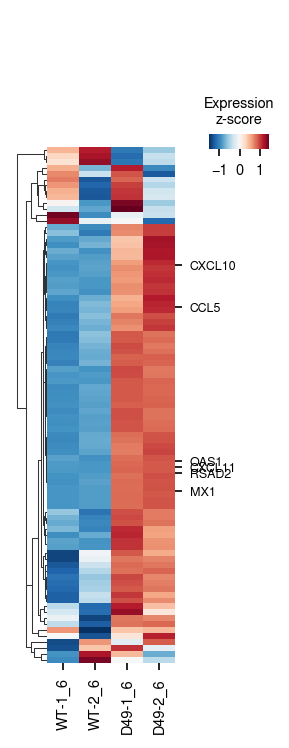

In [195]:
# d = np.log2(exps[
#     exps.gene_symbol.isin(go_result['t18_d49_high'].iloc[0].Genes.split(';'))
# ].set_index(['ensg', 'gene_symbol']) + 1)[['WT-t6-rep1', 'WT-t6-rep2', 'D49-t6-rep1', 'D49-t6-rep2', 'WT-t18-rep1', 'WT-t18-rep2', 'D49-t18-rep1', 'D49-t18-rep2']]
from matplotlib import lines, text
from matplotlib.patches import Rectangle, Patch

d = np.log2(exps[
    exps.gene_symbol.isin(go_result['t24_d49_high'].iloc[0].Genes.split(';'))
].set_index(['ensg', 'gene_symbol']) + 1)[['WT-1_6', 'WT-2_6', 'D49-1_6', 'D49-2_6']]
d = d.reset_index()[['gene_symbol', 'WT-1_6', 'WT-2_6', 'D49-1_6', 'D49-2_6']].set_index('gene_symbol')

p = sns.clustermap(d, z_score=0, figsize=(2, 5), cmap='RdBu_r', cbar_kws={'orientation': 'horizontal'}, col_cluster=False)
ax = p.cax
ax.set_position((0.7, 0.8, 0.20, 0.02))
ax.xaxis.set_label_position('top') 
ax.set_xlabel('Expression\nz-score', fontsize=7, labelpad=5)
# ax.set_xticklabels([-2, 0, 2], fontsize=7)
# ax.add_patch(Rectangle((-2, -2), 4, 4, fc='none', lw=0.75, color='k', clip_on=False))

d = p.data2d
indices = [i for i, g in enumerate(d.index.values) if g in genes]

p.ax_heatmap.set_yticks(indices)
p.ax_heatmap.set_yticklabels(d.index[indices].values, fontsize=6)

p.ax_heatmap.set_ylabel('')

# save_figures('result/6hpi_heatmap', exts=['png', 'eps'])

In [196]:
d.to_excel('result/6hpi_heatmap_table.xlsx')

In [36]:
from adjustText import adjust_text

In [37]:
genes = [
    'MX1',
    'OAS1',
    'IFNB1',
    'CCL3',
    'CCL5',
    'CXCL10',
    'CXCL11',
    'CCL20',
    'RSAD2',
    'TNFSF18',
]

In [38]:
d = t24_deseq_notnull.copy()
d['log10_padj'] = -np.log10(d.padj)

In [39]:
d[d.gene_symbol == 'IFNB1']

,gene_symbol,ensg,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,log10_padj


In [40]:
mask_132 = d.gene_symbol.isin(go_result['t24_d49_high'].iloc[0].Genes.split(';'))

In [41]:
d[d.gene_symbol == 'IFNB1']

,gene_symbol,ensg,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,log10_padj


In [55]:
t6_deseq

,gene_symbol,ensg,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,TSPAN6,ENSG00000000003,588.486327,0.155752,0.163384,0.953292,0.340442,0.656265
1,DPM1,ENSG00000000419,1242.991392,0.138273,0.124991,1.106264,0.268612,0.588603
2,SCYL3,ENSG00000000457,254.478863,0.024012,0.241659,0.099363,0.920850,0.974989
3,C1orf112,ENSG00000000460,182.125973,-0.181683,0.286317,-0.634553,0.525720,0.790611
4,FGR,ENSG00000000938,19.085791,-1.581041,0.832900,-1.898235,0.057665,NaN
...,...,...,...,...,...,...,...,...
23271,NaN,ENSG00000288398,120.622866,0.293930,0.324115,0.906869,0.364476,0.676707
23272,NaN,ENSG00000288436,1.043920,1.497646,3.775553,0.396669,0.691611,NaN
23273,NaN,ENSG00000288437,1.844320,1.286645,2.696786,0.477103,0.633289,NaN
23274,NaN,ENSG00000288473,23.242218,-0.050848,0.733601,-0.069313,0.944740,NaN


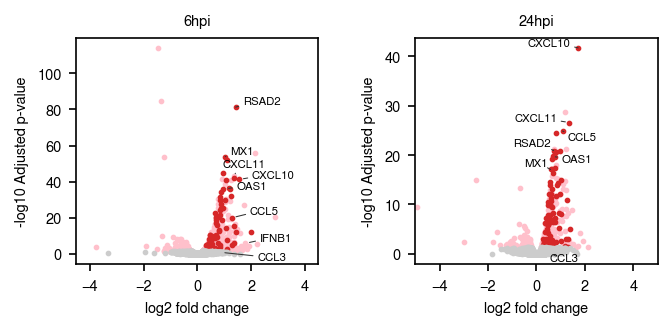

In [48]:
d = t6_deseq_notnull.copy()
d['log10_padj'] = -np.log10(d.padj)

fig = plt.figure(figsize=(5, 2))
ax = fig.add_subplot(121)

de_mask = (d.padj < 0.05)
mask_132 = d.gene_symbol.isin(go_result['t24_d49_high'].iloc[0].Genes.split(';'))

ax.scatter(-d.log2FoldChange[de_mask & ~mask_132], d.log10_padj[de_mask & ~mask_132], s=3, c='pink')
ax.scatter(-d.log2FoldChange[de_mask & mask_132], d.log10_padj[de_mask & mask_132], s=3, c='C3')
ax.scatter(-d.log2FoldChange[~de_mask], d.log10_padj[~de_mask], s=3, c='0.8')

# Labels
texts, x, y = [], [], []
texts = [ax.text(-r.log2FoldChange, r.log10_padj, r.gene_symbol, fontsize=5.5) for r in d.to_records() if r.gene_symbol in genes]
adjust_text(texts, -d.log2FoldChange.values, d.log10_padj.values, expand_text=(1.1, 1.5), expand_points=(1.5, 1.2), arrowprops=dict(arrowstyle='-', color='0.2', lw=0.5), va='bottom')

ax.set_xlim([-4.5, 4.5])
ax.set_xlabel('log2 fold change')
ax.set_ylabel('-log10 Adjusted p-value')
ax.set_title('6hpi', fontsize=7)

d = t24_deseq_notnull.copy()
d['log10_padj'] = -np.log10(d.padj)

ax = fig.add_subplot(122)

de_mask = (d.padj < 0.05)
mask_132 = d.gene_symbol.isin(go_result['t24_d49_high'].iloc[0].Genes.split(';'))

ax.scatter(-d.log2FoldChange[de_mask & ~mask_132], d.log10_padj[de_mask & ~mask_132], s=3, c='pink')
ax.scatter(-d.log2FoldChange[de_mask & mask_132], d.log10_padj[de_mask & mask_132], s=3, c='C3')
ax.scatter(-d.log2FoldChange[~de_mask], d.log10_padj[~de_mask], s=3, c='0.8')

# Labels
texts, x, y = [], [], []
texts = [ax.text(-r.log2FoldChange, r.log10_padj, r.gene_symbol, fontsize=5.5) for r in d.to_records() if r.gene_symbol in genes]
adjust_text(texts, -d.log2FoldChange.values, d.log10_padj.values, expand_text=(1.1, 1.5), expand_points=(1.5, 1.2), arrowprops=dict(arrowstyle='-', color='0.2', lw=0.5), va='bottom')

ax.set_xlim([-5, 5])
ax.set_xlabel('log2 fold change')
ax.set_ylabel('-log10 Adjusted p-value')
ax.set_title('24hpi', fontsize=7)

fig.subplots_adjust(wspace=0.4)

save_figures('result/volcano', exts=['png', 'eps'])

48
47


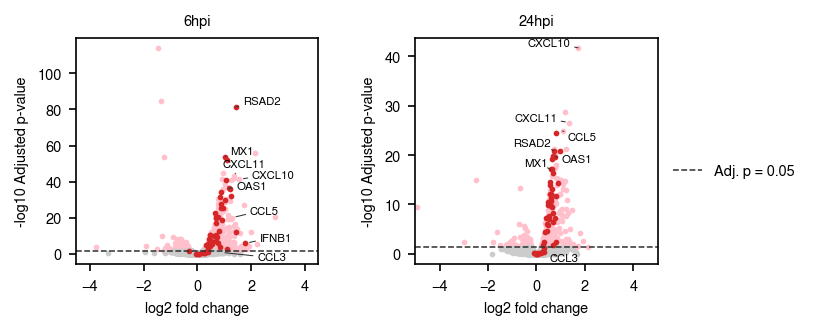

In [133]:
d = t6_deseq_notnull.copy()
d['log10_padj'] = -np.log10(d.padj)

fig = plt.figure(figsize=(5, 2))
ax = fig.add_subplot(121)

de_mask = (d.padj < 0.05)
# mask_132 = d.gene_symbol.isin(go_result['t24_d49_high'].iloc[0].Genes.split(';'))
mask_132 = d.gene_symbol.isin(interf_genes)
print(mask_132.sum())

ax.scatter(-d.log2FoldChange[de_mask & ~mask_132], d.log10_padj[de_mask & ~mask_132], s=3, c='pink')
# ax.scatter(-d.log2FoldChange[de_mask & mask_132], d.log10_padj[de_mask & mask_132], s=3, c='C3')
ax.scatter(-d.log2FoldChange[~(de_mask | mask_132)], d.log10_padj[~(de_mask | mask_132)], s=3, c='0.8')
ax.scatter(-d.log2FoldChange[mask_132], d.log10_padj[mask_132], s=3, c='C3')

# Labels
texts, x, y = [], [], []
texts = [ax.text(-r.log2FoldChange, r.log10_padj, r.gene_symbol, fontsize=5.5) for r in d.to_records() if r.gene_symbol in genes]
adjust_text(texts, -d.log2FoldChange.values, d.log10_padj.values, expand_text=(1.1, 1.5), expand_points=(1.5, 1.2), arrowprops=dict(arrowstyle='-', color='0.2', lw=0.5), va='bottom')

ax.set_xlim([-4.5, 4.5])
ax.set_xlabel('log2 fold change')
ax.axhline(-np.log10(0.05), lw=0.75, ls='--', c='0.2')
ax.set_ylabel('-log10 Adjusted p-value')
ax.set_title('6hpi', fontsize=7)

d = t24_deseq_notnull.copy()
d['log10_padj'] = -np.log10(d.padj)

ax = fig.add_subplot(122)

de_mask = (d.padj < 0.05)
# mask_132 = d.gene_symbol.isin(go_result['t24_d49_high'].iloc[0].Genes.split(';'))
mask_132 = d.gene_symbol.isin(interf_genes)
print(mask_132.sum())

ax.scatter(-d.log2FoldChange[de_mask & ~mask_132], d.log10_padj[de_mask & ~mask_132], s=3, c='pink')
# ax.scatter(-d.log2FoldChange[de_mask & mask_132], d.log10_padj[de_mask & mask_132], s=3, c='C3')
# ax.scatter(-d.log2FoldChange[~de_mask], d.log10_padj[~de_mask], s=3, c='0.8')
ax.scatter(-d.log2FoldChange[~(de_mask | mask_132)], d.log10_padj[~(de_mask | mask_132)], s=3, c='0.8')
ax.scatter(-d.log2FoldChange[mask_132], d.log10_padj[mask_132], s=3, c='C3')

# Labels
texts, x, y = [], [], []
texts = [ax.text(-r.log2FoldChange, r.log10_padj, r.gene_symbol, fontsize=5.5) for r in d.to_records() if r.gene_symbol in genes]
adjust_text(texts, -d.log2FoldChange.values, d.log10_padj.values, expand_text=(1.1, 1.5), expand_points=(1.5, 1.2), arrowprops=dict(arrowstyle='-', color='0.2', lw=0.5), va='bottom')

ax.set_xlim([-5, 5])
ax.set_xlabel('log2 fold change')
ax.set_ylabel('-log10 Adjusted p-value')
ax.axhline(-np.log10(0.05), lw=0.75, ls='--', c='0.2', label='Adj. p = 0.05')
ax.set_title('24hpi', fontsize=7)

ax.legend(frameon=False, bbox_to_anchor=(1.01, 0.5))

fig.subplots_adjust(wspace=0.4)

save_figures('result/volcano_interferon2', exts=['png', 'eps'])